In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os
from scipy.signal import savgol_filter  

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc
from joblib import dump
from sklearn.decomposition import PCA

import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import shutil
from torchvision.utils import save_image
import torchvision

In [ ]:
%mkdir data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
#!unzip /content/drive/MyDrive/cuda/sheet6/data/img_align_celeba.zip -d /content/data

In [ ]:
!cp /content/drive/MyDrive/cuda/sheet6/data/list_eval_partition.txt /content/data

In [ ]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((64, 64)),
#                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((64, 64)),
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

In [ ]:
B_SIZE = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CelebA_Dataset(Dataset):
    def __init__(self, data_dir, split, transform):
        super().__init__()
        self.img_dir = os.path.join(data_dir + "/img_align_celeba")
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.make_split()
    
    def make_split(self):
        partition_list_path = os.path.join(self.data_dir, "list_eval_partition.txt")
        partition_list = np.loadtxt(partition_list_path, dtype=str)
        if self.split == "train":
            self.img_names = partition_list[partition_list[:, 1].astype(float) == 0, 0]
        elif self.split == "test":
            self.img_names = partition_list[partition_list[:, 1].astype(float) > 0, 0]
            
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.img_names)
    
    def t(self, img):
        return self.transform(img)
        
    def __getitem__(self, idx):
        if type(idx) != int:
            file_names = [os.path.join(self.img_dir, self.img_names[id]) for id in idx]
            imgs = []
            for name in file_names:
                img = np.array(Image.open(name))
                if self.transform:
                    img = self.t(img)
                imgs.append(img)
            return np.stack(imgs)
                             
        file_name = os.path.join(self.img_dir, self.img_names[idx])
        img = np.array(Image.open(file_name))
        
        if self.transform:
            img = self.t(img)
    
        return img

In [ ]:
train_dataset = CelebA_Dataset("/content/data", "train", t)
test_dataset = CelebA_Dataset("/content/data", "test", test_transform)

In [ ]:
len(train_dataset)

162770

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 64, 64])


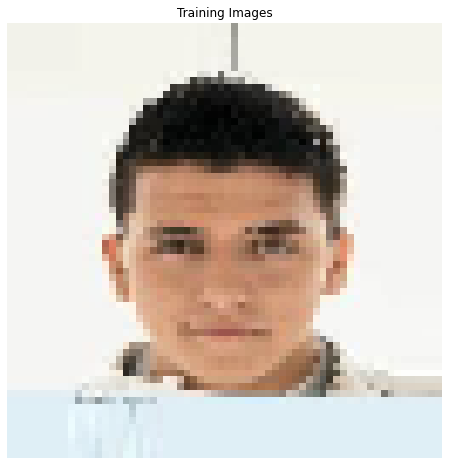

In [ ]:
real_batch = next(iter(train_loader))
print(real_batch.size())
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:256], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan1")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

if not os.path.exists("imgs1"):
    os.makedirs("imgs1")

if not os.path.exists("imgs1/training1"):
    os.makedirs("imgs1/training1")
shutil.rmtree("imgs1/training1")

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:

nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64


# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Learning rate for optimizers
lr = 0.0002

num_epochs = 10


LAMBDA_GP = 10

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        
        return self.main(input)

In [ ]:

netG = Generator().to(device)


netG.apply(weights_init)


print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            
        )

    def forward(self, input):
        return self.main(input)

In [ ]:

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [ ]:
def image_to_vector(img):
    """ Converting images into vectors """
    vector = img.view(img.shape[0], -1)
    return vector 

def vector_to_image(vector, shape=(1,32,32)):
    """ Converting flattened images into matrices """
    images = vector.view(vector.shape[0], *shape)
    return images

In [ ]:
def gradient_penalty(D, real, fake, device='cpu'):
    BATCH_SIZE, C, H, W = real.shape
    eps = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device) # eps for interpolate images
    interpolated_imgs = real * eps + (1 - eps) * fake
    
    d_interpolates = D(interpolated_imgs)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_imgs,
        outputs = d_interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
        )[0] # torch.autograd.grad() with grad_outputs will output a tuple, the frist element is the gradient
    
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1)
    grad_penalty = torch.mean(grad_norm - 1)**2
    return grad_penalty

In [ ]:
def train(dataloader,netG,netD):

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data.to(device)
           
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
           
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
           
            D_G_z1 = output.mean().item()

            gp_regulariztion = gradient_penalty(netD, real_cpu, fake, device=device)
            loss_D =D_G_z1 - D_x + gp_regulariztion * LAMBDA_GP
           
            loss_D.backward(retain_graph=True)
            # Compute error of D as sum over the fake and the real batches
           
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            D_G_z2 = -1 * output.mean()
            # Update G
            optimizerG.step()

            writer.add_scalar(f'Loss/Discriminator Loss', loss_D.item(), global_step=iters)
            writer.add_scalar(f'Loss/Generator Loss', D_G_z2.item(), global_step=iters)
            writer.add_scalars(f'Comb_Loss/Losses', {
                                'Discriminator': loss_D.item(),
                                'Generator':  D_G_z2.item()
                            }, iters)  
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                      % (epoch, num_epochs, i, len(dataloader),
                         loss_D.item(), D_G_z2.item()))

            # Save Losses for plotting later
            G_losses.append(D_G_z2.item())
            D_losses.append(loss_D.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                writer.add_image('images', vutils.make_grid(fake, padding=2, normalize=True), global_step=iters)

            iters += 1
    return G_losses,D_losses,img_list

In [ ]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [ ]:
image_size=32
G_losses,D_losses,img_list=train(train_loader,netG,netD)

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0/5][0/636]	Loss_D: -4.3571	Loss_G: 6.9287	
[0/5][50/636]	Loss_D: -5.7364	Loss_G: 9.1270	
[0/5][100/636]	Loss_D: -4.3023	Loss_G: 8.7847	
[0/5][150/636]	Loss_D: -7.5736	Loss_G: 10.6616	
[0/5][200/636]	Loss_D: -5.8697	Loss_G: 9.6355	
[0/5][250/636]	Loss_D: -8.0451	Loss_G: 11.7640	
[0/5][300/636]	Loss_D: -6.0779	Loss_G: 9.6805	
[0/5][350/636]	Loss_D: -6.1442	Loss_G: 9.2855	
[0/5][400/636]	Loss_D: -6.4317	Loss_G: 8.8970	
[0/5][450/636]	Loss_D: -4.8175	Loss_G: 8.5467	
[0/5][500/636]	Loss_D: -5.4397	Loss_G: 8.3931	
[0/5][550/636]	Loss_D: -4.2733	Loss_G: 8.3955	
[0/5][600/636]	Loss_D: -4.7056	Loss_G: 8.2933	
[1/5][0/636]	Loss_D: -5.4104	Loss_G: 8.6308	
[1/5][50/636]	Loss_D: -3.7823	Loss_G: 8.4702	
[1/5][100/636]	Loss_D: -6.3053	Loss_G: 9.9646	
[1/5][150/636]	Loss_D: -3.7635	Loss_G: 8.5477	
[1/5][200/636]	Loss_D: -4.4201	Loss_G: 8.3456	
[1/5][250/636]	Loss_D: -4.9293	Loss_G: 8.4439	
[1/5][300/636]	Loss_D: -4.6630	Loss_G: 8.0085	
[1/5][350/636]	Loss_D: -4.9253	Loss_G: 8.2455	
[1/5][400/636]	Lo

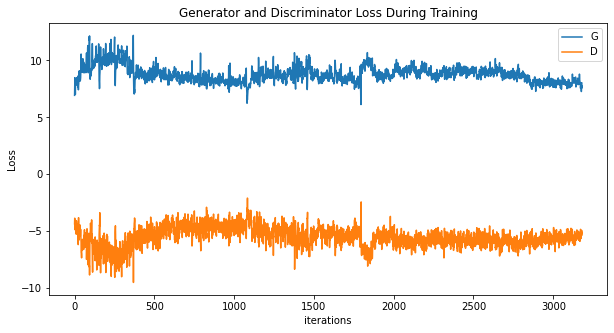

In [91]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [93]:

%%shell 
jupyter nbconvert --to html /content/Sheet07_WGAN.ipynb

[NbConvertApp] Converting notebook /content/Sheet07_WGAN.ipynb to html
[NbConvertApp] Writing 697823 bytes to /content/Sheet07_WGAN.html
